# Validação de Modelos e métodos automáticos
- Holdout vs. Sem Holdout 
- Métricas penalizadas por complexidade – Para casos com poucos dados (BIC, AIC).
- Métricas para avaliação no holdout – ASE, MAE, MAPE, RMSE.
- Auto ARIMA 

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
from funcoes import all_ac, plot_forecast, teste_estacionariedade, diagnostico, compara_previsoes, correlacao_cruzada, compara_estatisticas
plt.rcParams["figure.figsize"] = [12, 5]
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import pmdarima as pm
from statsmodels.datasets import co2, get_rdataset

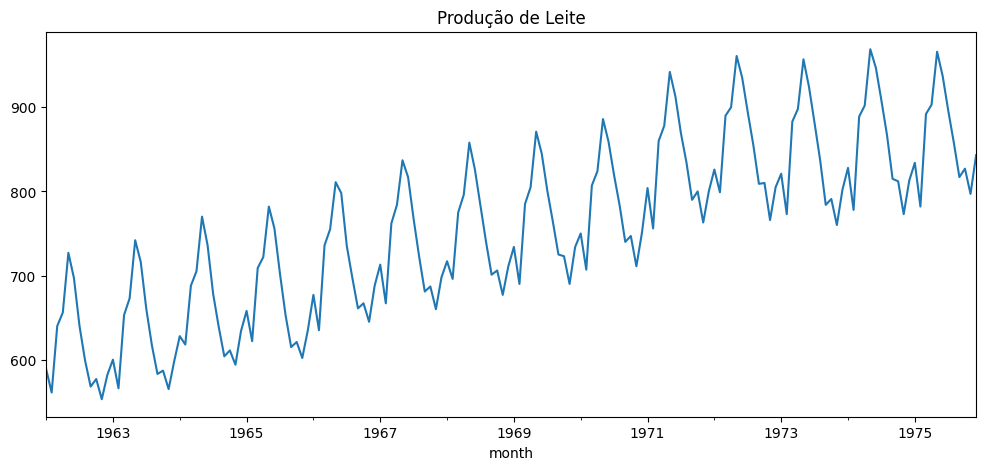

In [2]:
milk = pd.read_csv('../../dados/milk_production.csv')
milk.index = pd.to_datetime(milk['month'])
milk.index.freq = 'MS'
milk_prod = pd.Series(milk['production'], name="produção de leite")
milk_prod.plot()
plt.title('Produção de Leite')
plt.show()

## Holdout

In [3]:
train, test = pm.model_selection.train_test_split(milk_prod, test_size=0.10)
train

month
1962-01-01    589
1962-02-01    561
1962-03-01    640
1962-04-01    656
1962-05-01    727
             ... 
1974-03-01    889
1974-04-01    902
1974-05-01    969
1974-06-01    947
1974-07-01    908
Freq: MS, Name: produção de leite, Length: 151, dtype: int64

In [4]:
test

month
1974-08-01    867
1974-09-01    815
1974-10-01    812
1974-11-01    773
1974-12-01    813
1975-01-01    834
1975-02-01    782
1975-03-01    892
1975-04-01    903
1975-05-01    966
1975-06-01    937
1975-07-01    896
1975-08-01    858
1975-09-01    817
1975-10-01    827
1975-11-01    797
1975-12-01    843
Freq: MS, Name: produção de leite, dtype: int64

In [5]:
len(milk_prod)/10

16.8

In [6]:
periodos = 24
train = milk_prod[:-periodos]
test = milk_prod[-periodos:]
train

month
1962-01-01    589
1962-02-01    561
1962-03-01    640
1962-04-01    656
1962-05-01    727
             ... 
1973-08-01    837
1973-09-01    784
1973-10-01    791
1973-11-01    760
1973-12-01    802
Freq: MS, Name: produção de leite, Length: 144, dtype: int64

## Métricas calculadas no holdout


<Axes: xlabel='month'>

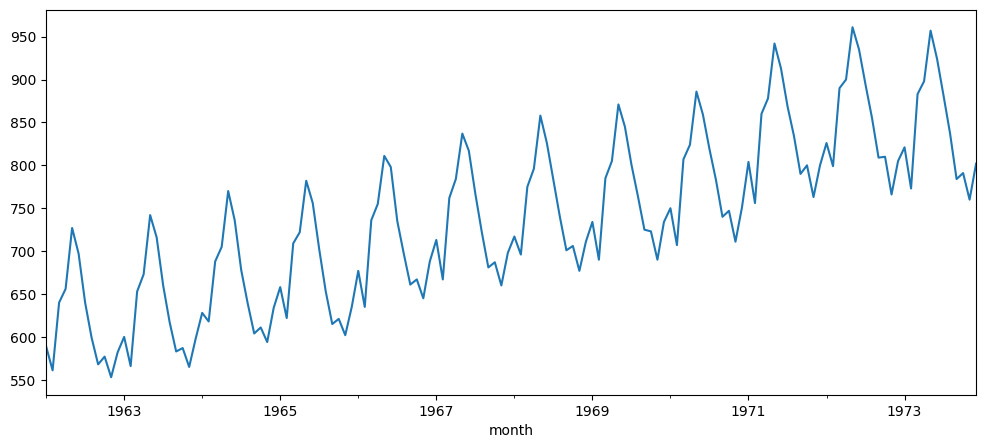

In [7]:
train.plot()

In [8]:
teste_estacionariedade(train)

('Não Estacionário', 'Não Estacionário')

                                      SARIMAX Results                                       
Dep. Variable:                    produção de leite   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -452.127
Date:                              Fri, 02 May 2025   AIC                            910.254
Time:                                      13:02:35   BIC                            918.879
Sample:                                  01-01-1962   HQIC                           913.759
                                       - 12-01-1973                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2660      0.086     -3.085      0.002      -0.435      -0.097
ma.S.L12      -0.63

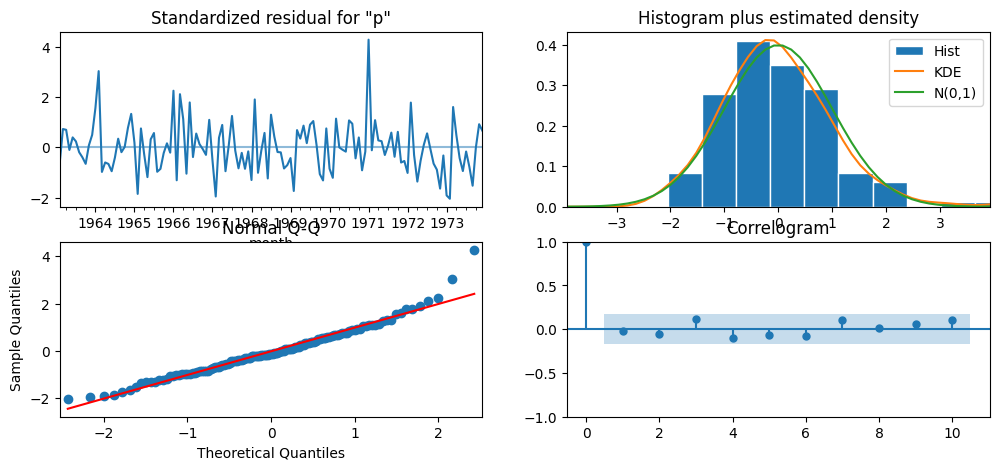

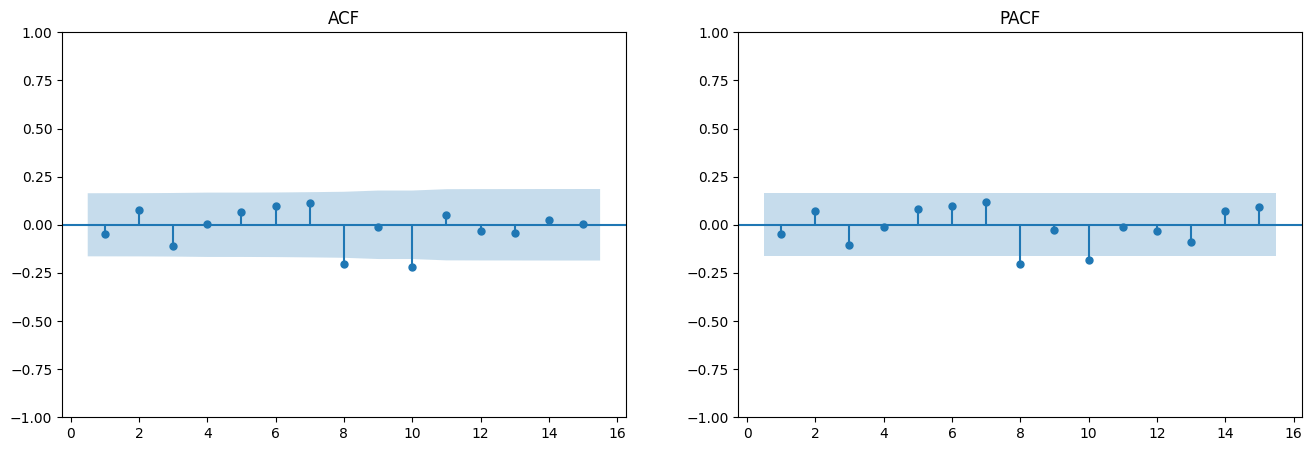

In [9]:
model = SARIMAX(train, order = (1,1,0), seasonal_order=(0,1,1,12)).fit(disp=False)
diagnostico(model)

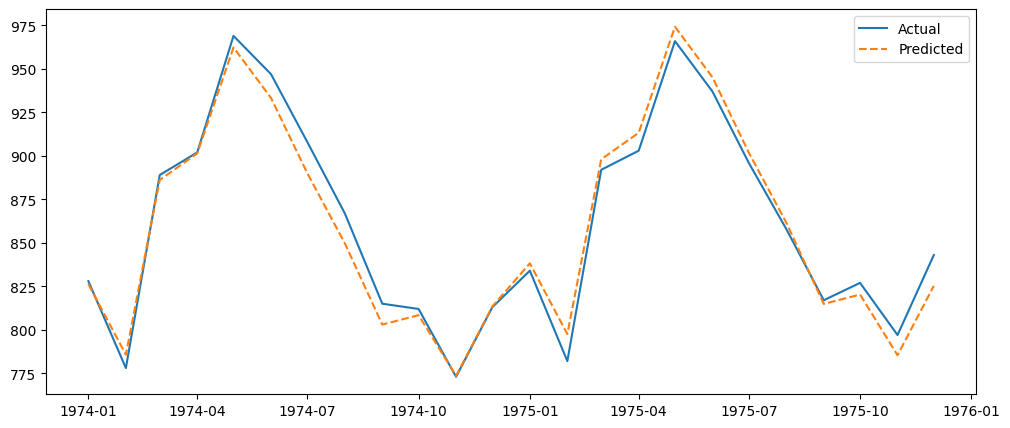

In [10]:
predictions = model.predict(start=test.index[0], end=test.index[-1], dynamic=False)
plt.plot(test, label='Actual')
plt.plot(predictions, label='Predicted', linestyle='--')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
residuals = test - predictions
sum_residuals = residuals.sum()
mae = mean_absolute_error(test, predictions)
mape = np.mean(np.abs(residuals / test)) * 100
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f"Soma dos Residuos: {sum_residuals}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

Soma dos Residuos: 43.49091596929327
MAE: 7.7140621279009975
MAPE: 0.8943223152571471%
MSE: 89.98816377943791
RMSE: 9.486209136395734


                               SARIMAX Results                                
Dep. Variable:      produção de leite   No. Observations:                  144
Model:               SARIMAX(4, 1, 0)   Log Likelihood                -723.326
Date:                Fri, 02 May 2025   AIC                           1456.652
Time:                        13:02:36   BIC                           1471.467
Sample:                    01-01-1962   HQIC                          1462.672
                         - 12-01-1973                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0057      0.078      0.073      0.942      -0.147       0.159
ar.L2          0.3749      0.083      4.538      0.000       0.213       0.537
ar.L3         -0.1210      0.096     -1.264      0.2

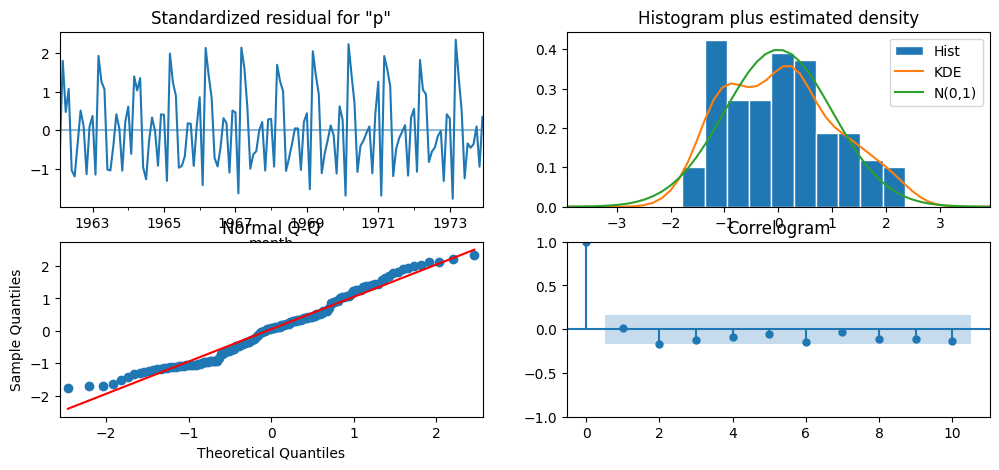

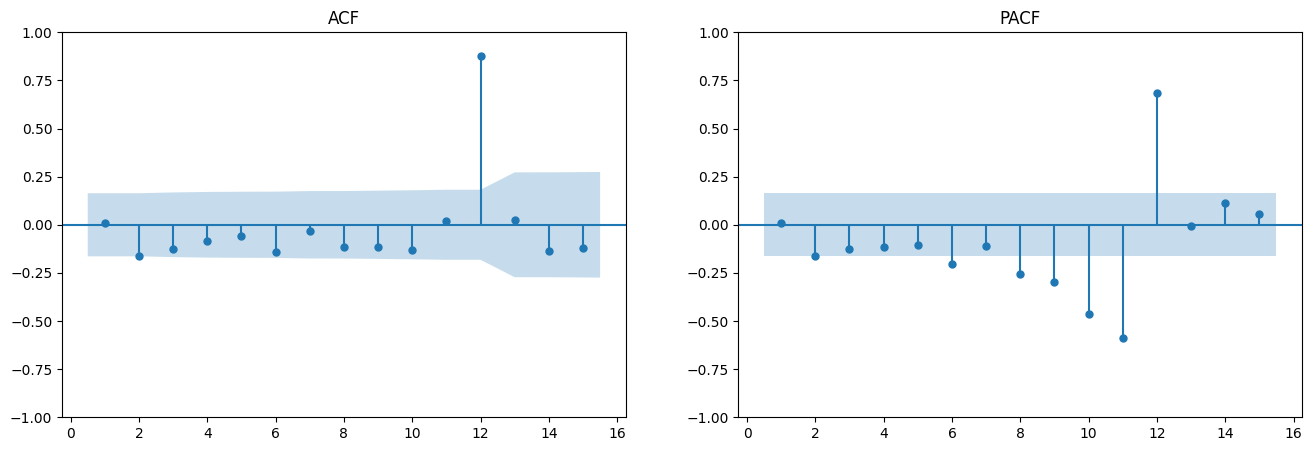

In [12]:
model = SARIMAX(train, order = (4,1,0)).fit(disp=False)
diagnostico(model)

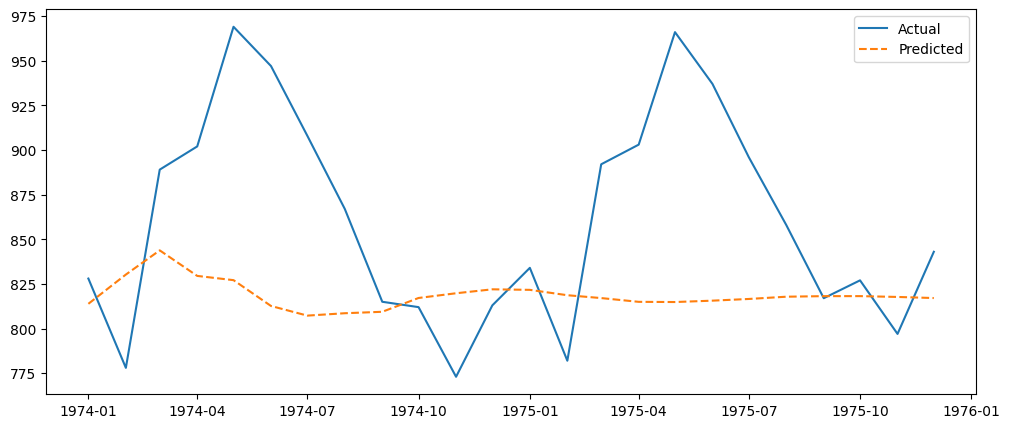

In [13]:
predictions = model.forecast(24)
plt.plot(test, label='Actual')
plt.plot(predictions, label='Predicted', linestyle='--')
plt.legend()
plt.show()

In [14]:
residuals = test - predictions
sum_residuals = residuals.sum()
mae = mean_absolute_error(test, predictions)
mape = np.mean(np.abs(residuals / test)) * 100
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f"Soma dos Residuos: {sum_residuals}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

Soma dos Residuos: 1003.3428266992071
MAE: 56.11040861982881
MAPE: 6.251084559789912%
MSE: 5243.285202545301
RMSE: 72.41053240064805


## Métricas penalizadas

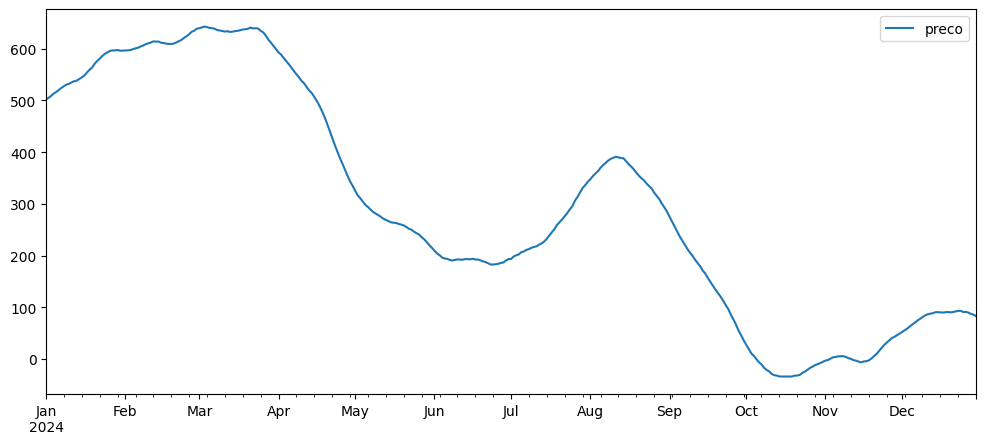

In [15]:
Y = pd.read_csv('../../dados/ARIMA_Exemplo.csv')
Y.index = pd.date_range(start='2024-01-01', periods = 365)
Y.plot()
plt.show()

In [16]:
teste_estacionariedade(Y)

('Não Estacionário', 'Não Estacionário')

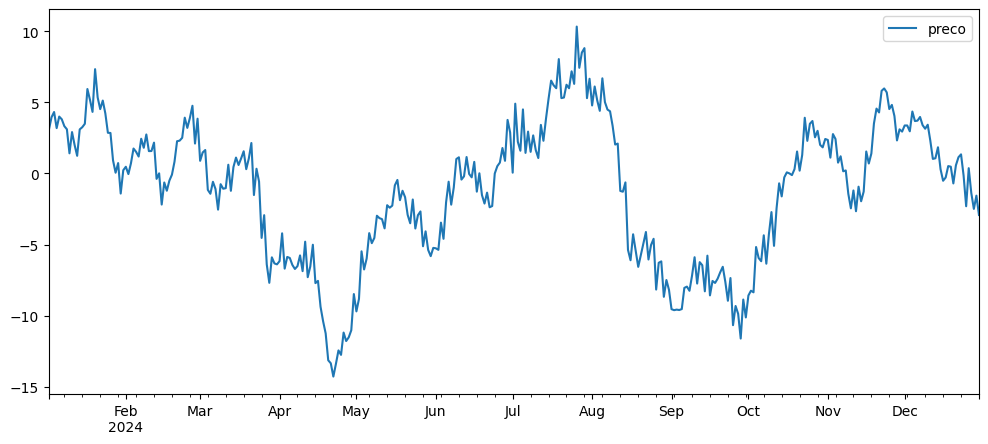

('Estacionário', 'Estacionário')

In [17]:
primeira_ordem = Y.diff().dropna()
primeira_ordem.plot()
plt.show()
teste_estacionariedade(primeira_ordem)

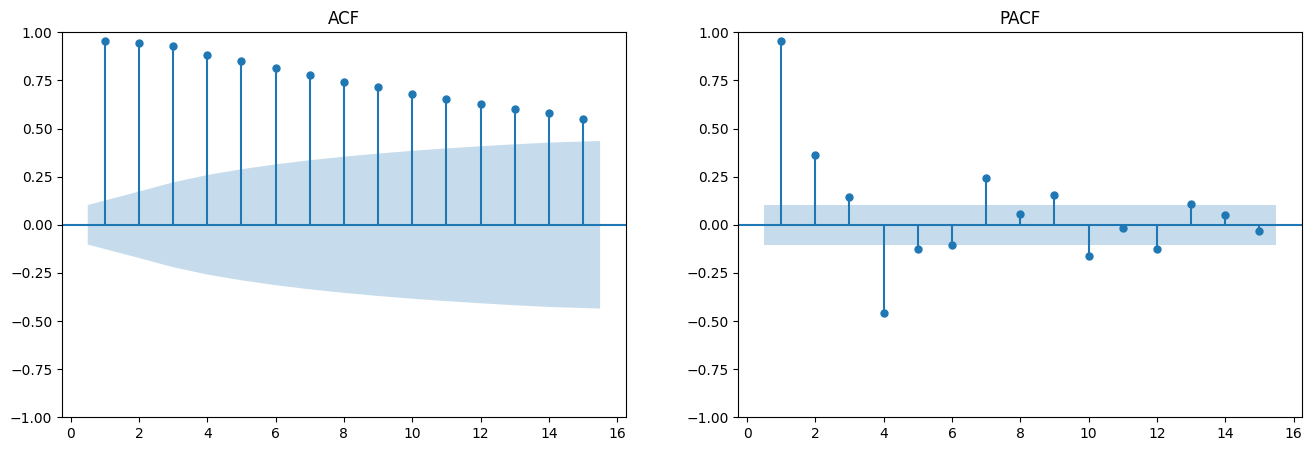

In [18]:
all_ac(primeira_ordem)

                               SARIMAX Results                                
Dep. Variable:      produção de leite   No. Observations:                  144
Model:               SARIMAX(4, 1, 0)   Log Likelihood                -723.326
Date:                Fri, 02 May 2025   AIC                           1456.652
Time:                        13:02:36   BIC                           1471.467
Sample:                    01-01-1962   HQIC                          1462.672
                         - 12-01-1973                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0057      0.078      0.073      0.942      -0.147       0.159
ar.L2          0.3749      0.083      4.538      0.000       0.213       0.537
ar.L3         -0.1210      0.096     -1.264      0.2

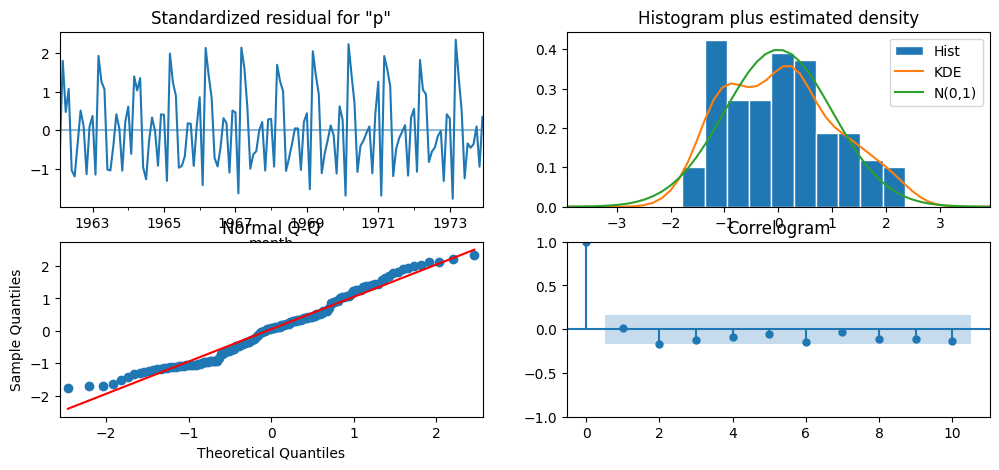

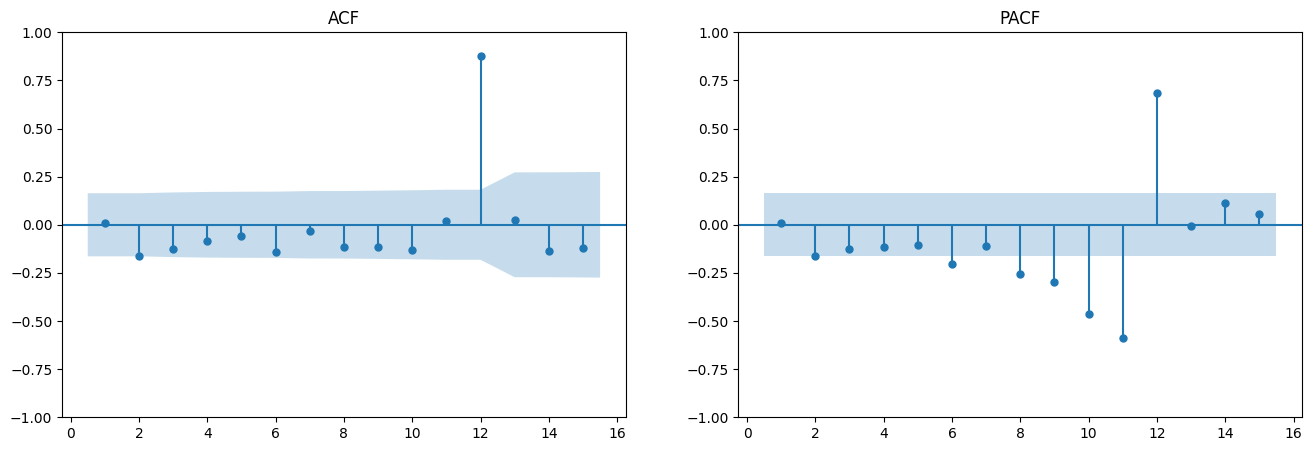

In [19]:
model1 = ARIMA(Y, order=(2, 1, (0,0,1))).fit()
diagnostico(model)

In [20]:
print(f"AIC: {model.aic}")
print(f"BIC: {model.bic}")
print(f"AICC: {model.aicc}")
print(f"HQIC: {model.hqic}")

AIC: 1456.652359664074
BIC: 1471.4665828153736
AICC: 1457.0903158684537
HQIC: 1462.6721505691314


                               SARIMAX Results                                
Dep. Variable:                  preco   No. Observations:                  365
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -514.589
Date:                Fri, 02 May 2025   AIC                           1041.178
Time:                        13:02:37   BIC                           1064.561
Sample:                    01-01-2024   HQIC                          1050.472
                         - 12-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5211      0.053      9.862      0.000       0.418       0.625
ar.L2          0.4296      0.054      7.886      0.000       0.323       0.536
ma.L1         -0.0321      0.025     -1.286      0.1

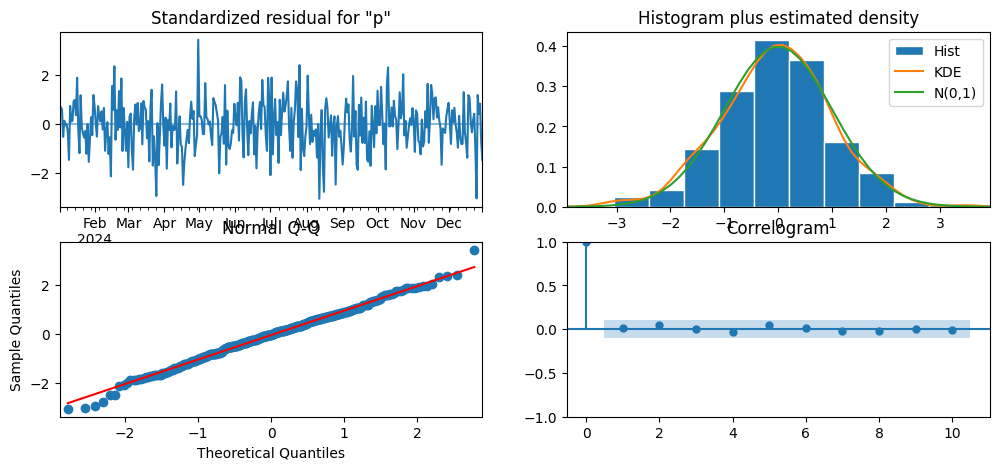

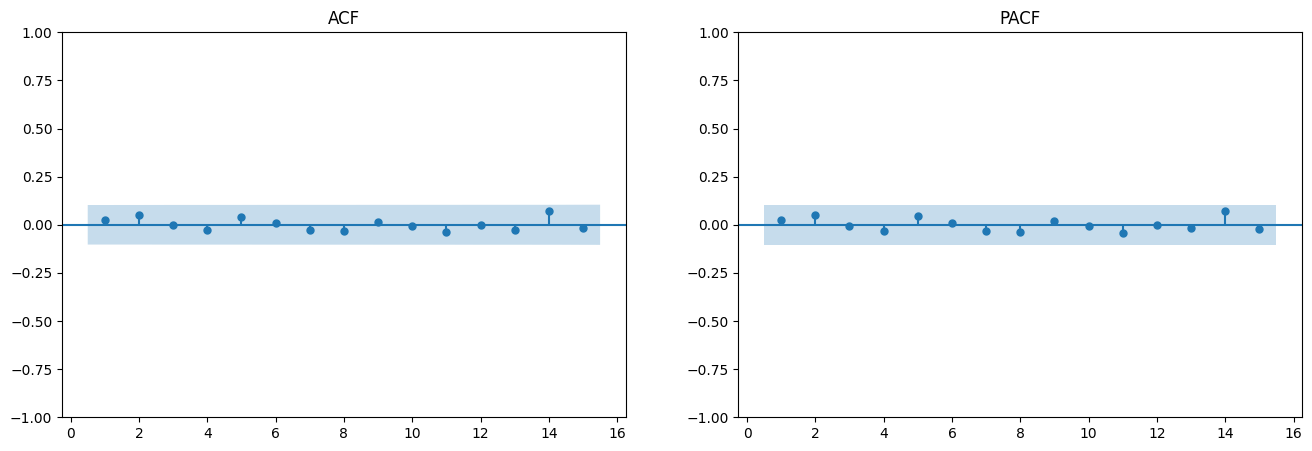

AIC: 1041.178058406045
BIC: 1064.5609816118654
AICC: 1041.413352523692
HQIC: 1050.4716964765148


In [21]:
model = ARIMA(Y, order=(2, 1, 3)).fit()
diagnostico(model)
print(f"AIC: {model.aic}")
print(f"BIC: {model.bic}")
print(f"AICC: {model.aicc}")
print(f"HQIC: {model.hqic}")

In [22]:
model1 = ARIMA(Y, order=(2, 1, (0,0,1))).fit()
model2 = ARIMA(Y, order=(2, 1, 3)).fit()
for model in [model1,model2]:
    print(f"AIC: {model.aic}")
    print(f"BIC: {model.bic}")
    print(f"AICC: {model.aicc}")
    print(f"HQIC: {model.hqic}")

AIC: 1038.5493263531991
BIC: 1054.1379418237461
AICC: 1038.6607469660125
HQIC: 1044.7450850668456
AIC: 1041.178058406045
BIC: 1064.5609816118654
AICC: 1041.413352523692
HQIC: 1050.4716964765148


## Auto ARIMA

<Axes: xlabel='month'>

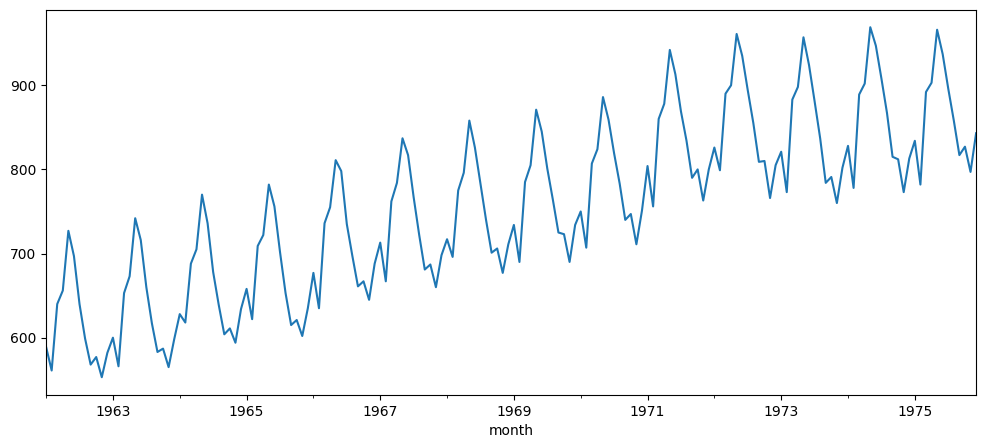

In [23]:
milk_prod.plot()

In [24]:
auto_model = pm.auto_arima(milk_prod, 
                           seasonal=True, 
                           m=12, 
                           test='adf', 
                           information_criterion='aic',
                           trace=True)

Performing stepwise search to minimize aic


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1070.222, Time=0.68 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1119.969, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1081.584, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1066.296, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1114.995, Time=0.01 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1068.030, Time=0.11 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1067.976, Time=0.25 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1082.123, Time=0.05 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1072.280, Time=0.04 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1068.064, Time=0.10 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1067.796, Time=0.09 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1066.207, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1114.845, Time=0.01 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1067.913, Time=0.09 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,2)[12]             : AIC=1067.857, Time=0.21 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=1067.922, Time=0.09 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1066.696, Time=0.29 sec
 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=1068.200, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,1,1)[12]          
Total fit time: 3.766 seconds


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [25]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -530.104
Date:                              Fri, 02 May 2025   AIC                           1066.207
Time:                                      13:02:41   BIC                           1075.337
Sample:                                  01-01-1962   HQIC                          1069.916
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2253      0.077     -2.925      0.003      -0.376      -0.074
ma.S.L12      -0.6190      0.070     -8.825      0.000      -0.757      -0.482
sigma2        52.6908      4.897     10.759      0.000      43.093      62.289
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.11
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.74
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
auto_model = pm.auto_arima(milk_prod, 
                           seasonal=True, 
                           m=12, 
                           test='adf', 
                           information_criterion='oob',
                           out_of_sample_size=24,
                           trace=True)

Performing stepwise search to minimize oob


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(2,1,2)(1,1,1)[12]             : OOB=87.837, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : OOB=641.625, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : OOB=381.460, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : OOB=92.236, Time=0.12 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(2,1,2)(0,1,1)[12]             : OOB=88.880, Time=0.27 sec
 ARIMA(2,1,2)(1,1,0)[12]             : OOB=333.415, Time=0.17 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,1,1)[12]             : OOB=101.401, Time=0.99 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,1,2)[12]             : OOB=inf, Time=0.95 sec
 ARIMA(2,1,2)(0,1,0)[12]             : OOB=386.166, Time=0.12 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(2,1,2)(0,1,2)[12]             : OOB=87.627, Time=0.63 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,2)[12]             : OOB=87.862, Time=0.45 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,2)[12]             : OOB=90.509, Time=0.80 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,1,2)[12]             : OOB=89.494, Time=0.95 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,1,2)[12]             : OOB=89.649, Time=1.66 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,2)[12]             : OOB=88.981, Time=0.43 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,1,2)[12]             : OOB=89.215, Time=0.99 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,1,2)[12]             : OOB=91.875, Time=1.09 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,1,2)[12]             : OOB=89.997, Time=1.85 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,1,2)[12] intercept   : OOB=103.698, Time=0.52 sec

Best model:  ARIMA(2,1,2)(0,1,2)[12]          
Total fit time: 12.530 seconds


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [27]:
model = pm.auto_arima(train, 
                      seasonal=True,
                      with_intercept=True,
                      d=1,
                      max_d=2,
                      start_p=0, max_p=2,
                      start_q=0, max_q=2,
                      m=12,
                      D=1,
                      max_D=2,
                      start_P=0, max_P=2,
                      start_Q=0, max_Q=2,
                      information_criterion='aic',
                      stepwise=False,
                      out_of_sample_siz=24,
                      test = 'kpss',
                      score='mape',
                      trace=True)

/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=959.705, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=919.834, Time=0.05 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=921.714, Time=0.19 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=935.247, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=921.743, Time=0.08 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,2)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=927.696, Time=0.18 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,1)[12] intercept   : AIC=922.898, Time=0.27 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,2)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=949.390, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=911.409, Time=0.07 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=913.332, Time=0.27 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=925.793, Time=0.11 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=913.348, Time=0.10 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,2)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,1,1)(2,1,0)[12] intercept   : AIC=918.807, Time=0.19 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,1)[12] intercept   : AIC=914.732, Time=0.30 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,2)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(0,1,2)(0,1,0)[12] intercept   : AIC=951.312, Time=0.03 sec
 ARIMA(0,1,2)(0,1,1)[12] intercept   : AIC=913.304, Time=0.10 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,2)[12] intercept   : AIC=915.195, Time=0.25 sec
 ARIMA(0,1,2)(1,1,0)[12] intercept   : AIC=927.157, Time=0.11 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,1)[12] intercept   : AIC=915.218, Time=0.12 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,2)[12] intercept   : AIC=inf, Time=0.67 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,1,0)[12] intercept   : AIC=920.429, Time=0.27 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,1,1)[12] intercept   : AIC=916.634, Time=0.38 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=950.447, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=912.090, Time=0.07 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,2)[12] intercept   : AIC=913.939, Time=0.26 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=926.040, Time=0.08 sec
 ARIMA(1,1,0)(1,1,1)[12] intercept   : AIC=913.972, Time=0.11 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,2)[12] intercept   : AIC=inf, Time=0.94 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=919.073, Time=0.24 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[12] intercept   : AIC=915.348, Time=0.35 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(1,1,1)(0,1,0)[12] intercept   : AIC=951.342, Time=0.03 sec
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=913.348, Time=0.09 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,2)[12] intercept   : AIC=915.254, Time=0.37 sec
 ARIMA(1,1,1)(1,1,0)[12] intercept   : AIC=927.480, Time=0.13 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,1)[12] intercept   : AIC=915.274, Time=0.14 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.15 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,0)[12] intercept   : AIC=920.588, Time=0.29 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,1)[12] intercept   : AIC=916.674, Time=0.47 sec
 ARIMA(1,1,2)(0,1,0)[12] intercept   : AIC=inf, Time=0.13 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=911.489, Time=0.30 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,2)[12] intercept   : AIC=917.134, Time=0.39 sec
 ARIMA(1,1,2)(1,1,0)[12] intercept   : AIC=928.962, Time=0.18 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,1)[12] intercept   : AIC=917.159, Time=0.37 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,1,0)[12] intercept   : AIC=922.369, Time=0.53 sec
 ARIMA(2,1,0)(0,1,0)[12] intercept   : AIC=950.669, Time=0.03 sec
 ARIMA(2,1,0)(0,1,1)[12] intercept   : AIC=912.840, Time=0.09 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,2)[12] intercept   : AIC=914.767, Time=0.31 sec
 ARIMA(2,1,0)(1,1,0)[12] intercept   : AIC=926.987, Time=0.12 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,1)[12] intercept   : AIC=914.782, Time=0.16 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,2)[12] intercept   : AIC=inf, Time=1.06 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,0)[12] intercept   : AIC=920.245, Time=0.31 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,1)[12] intercept   : AIC=916.225, Time=0.45 sec
 ARIMA(2,1,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.14 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,1)[12] intercept   : AIC=910.809, Time=0.21 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,2)[12] intercept   : AIC=912.756, Time=0.69 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,0)[12] intercept   : AIC=inf, Time=0.38 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,1)[12] intercept   : AIC=912.766, Time=0.27 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,1,0)[12] intercept   : AIC=917.574, Time=0.79 sec
 ARIMA(2,1,2)(0,1,0)[12] intercept   : AIC=946.368, Time=0.11 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,1,1)[12] intercept   : AIC=915.363, Time=0.24 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,1,0)[12] intercept   : AIC=928.560, Time=0.26 sec

Best model:  ARIMA(2,1,1)(0,1,1)[12] intercept
Total fit time: 21.127 seconds


In [28]:
df = pd.read_csv('../../dados/clicks_original.csv')
df.index = pd.to_datetime(df['date'])
df = df.drop(['date'], axis=1)
df.index.freq = 'D'
df = df[:-1] # Tirando o último ponto por ser um outlier, vou discutir isso depois
y = df['clicks']
x = df['price'].values.reshape(-1, 1)

/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_67046/620098537.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df['date'])


In [29]:
auto_model = pm.auto_arima(y, X=x,
                           information_criterion='aic',
                           trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2640.383, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2636.162, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2637.320, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2638.384, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2636.758, Time=0.02 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2631.170, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2634.371, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2634.244, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2638.275, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2629.364, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2635.868, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2634.147, Time=0.00 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2631.135, Time=0.04 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2630.989, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2636.173, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2634.691, Time=0.01 sec


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2629.968, Time=0.06 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.490 seconds


In [30]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  134
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1310.682
Date:                Fri, 02 May 2025   AIC                           2629.364
Time:                        13:03:15   BIC                           2640.955
Sample:                    04-01-2008   HQIC                          2634.074
                         - 08-12-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           234.3189     30.653      7.644      0.000     174.239     294.398
ar.L1          0.9736      0.028     35.357      0.000       0.920       1.028
ma.L1         -0.8796      0.059    -14.833      0.000      -0.996      -0.763
sigma2      1.826e+07      0.000    4.4e+10      0.000    1.83e+07    1.83e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               145.50
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             1.55
Prob(H) (two-sided):                  0.74   Kurtosis:                         7.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.69e+25. Standard errors may be unstable.
"""